In [1]:
import os
import sys
import h5py
import argparse
import numpy as np
from collections import Counter

# 3rd party imports
from sklearn import manifold
from keras.models import Model
from keras import backend as K
from IPython.display import Image

# ML4CVD Imports
sys.path.append("../ml4cvd")
from arguments import parse_args
from tensor_generators import big_batch_from_minibatch_generator, test_train_valid_tensor_generators
from recipes import train_shallow_model, train_multimodal_multitask, test_multimodal_multitask
from models import make_multimodal_to_multilabel_model, train_model_from_generators, make_hidden_layer_model

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/', 
            '--input_tensors', 'mri_systole_diastole_weighted', 
            '--output_tensors', 'mri_systole_diastole_segmented_weighted', 'lv_mass', 
            'end_systole_volume', 'end_diastole_volume', 'ejection_fraction',
            '--batch_size', '12',
            '--pool_z', '1',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--u_connect',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '24',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_systole_diastole_une_mass.hd5',
            '--id', 'mri_systole_diastole_unet_lv_mass_diseases']
args = parse_args()
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds, True)
model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-07 23:10:42,989 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_systole_diastole_unet_lv_mass_diseases/log_2019-05-07_23-10_0.log.
2019-05-07 23:10:42,990 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=12, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2

2019-05-07 23:11:26,974 - tensor_generators:222 - INFO - Input tensor 'input_mri_systole_diastole' has shape (288, 256, 256, 2, 1)
2019-05-07 23:11:27,648 - tensor_generators:225 - INFO - Output tensor 'output_mri_systole_diastole_segmented_categorical' has shape (288, 256, 256, 2, 3)
2019-05-07 23:11:27,651 - tensor_generators:225 - INFO - Output tensor 'output_lv_mass_continuous' has shape (288, 1)
2019-05-07 23:11:27,653 - tensor_generators:225 - INFO - Output tensor 'output_end_systole_volume_continuous' has shape (288, 1)
2019-05-07 23:11:27,655 - tensor_generators:225 - INFO - Output tensor 'output_end_diastole_volume_continuous' has shape (288, 1)
2019-05-07 23:11:27,657 - tensor_generators:225 - INFO - Output tensor 'output_ejection_fraction_continuous' has shape (288, 1)


In [6]:
layer_name = 'embed'
d1 = model.get_layer(layer_name)
w1 = d1.get_weights()
for w in w1:
    print(w.shape)
embed_model = make_hidden_layer_model(model, 'input_mri_systole_diastole', layer_name)
embed_model.summary()
print(list(test_data.keys()))
x_embed = embed_model.predict(test_data, batch_size=args.batch_size)
predictions = model.predict(test_data, batch_size=args.batch_size)

(16, 64)
(64,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mri_systole_diastole (Inp (None, 256, 256, 2,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 256, 256, 2,  608         input_mri_systole_diastole[0][0] 
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 256, 256, 2,  18464       conv3d_1[0][0]                   
__________________________________________________________________________________________________
average_pooling3d_1 (AveragePoo (None, 128, 128, 2,  0           conv3d_2[0][0]                   
______________________________________________________________________________________________

In [7]:
categorical_labels = ['Genetic-sex_Female_0_0', 'hypertension', 'coronary_artery_disease', 'Handedness-chiralitylaterality_Righthanded_0_0']
continuous_labels = ['22200_Year-of-birth_0_0|34_Year-of-birth_0_0', '21001_Body-mass-index-BMI_0_0', '1070_Time-spent-watching-television-TV_0_0', '102_Pulse-rate-automated-reading_0_0', '1488_Tea-intake_0_0', '21002_Weight_0_0']
label_dict = {k: np.zeros((len(test_paths))) for k in categorical_labels + continuous_labels}
for i, tp in enumerate(test_paths):
    hd5 = h5py.File(tp, 'r')
    #print(list(hd5['continuous'].keys()))
    for k in categorical_labels:
        if k in hd5['categorical']:
            label_dict[k][i] = 1
        elif k in hd5 and hd5[k][0] == 1:
            label_dict[k][i] = 1
    for mk in continuous_labels:
        for k in mk.split('|'):
            if k in hd5['continuous']:
                label_dict[mk][i] = hd5['continuous'][k][0]

print(list(label_dict.keys()))
print(label_dict['22200_Year-of-birth_0_0|34_Year-of-birth_0_0'])

['Genetic-sex_Female_0_0', 'hypertension', 'coronary_artery_disease', 'Handedness-chiralitylaterality_Righthanded_0_0', '22200_Year-of-birth_0_0|34_Year-of-birth_0_0', '21001_Body-mass-index-BMI_0_0', '1070_Time-spent-watching-television-TV_0_0', '102_Pulse-rate-automated-reading_0_0', '1488_Tea-intake_0_0', '21002_Weight_0_0']
[1947. 1961. 1944. 1947. 1956. 1951. 1966. 1951. 1954. 1958. 1955. 1945.
 1954. 1949. 1951. 1948. 1949. 1957. 1965. 1962. 1966. 1942. 1949. 1963.
 1949. 1940. 1946. 1946. 1945. 1960. 1952. 1942. 1946. 1951. 1949. 1960.
 1956. 1953. 1947. 1948. 1941. 1958. 1960. 1951. 1960. 1946. 1943. 1954.
 1956. 1964. 1952. 1967. 1951. 1951. 1954. 1954. 1945. 1955. 1958. 1950.
 1965. 1967. 1946. 1961. 1945. 1952. 1950. 1947. 1944. 1964. 1944. 1958.
 1949. 1944. 1954. 1949. 1965. 1947. 1965. 1952. 1956. 1940. 1951. 1963.
 1962. 1948. 1951. 1938. 1943. 1947. 1969. 1943. 1947. 1951. 1961. 1943.
 1965. 1951. 1952. 1952. 1956. 1954. 1958. 1947. 1948. 1944. 1957. 1960.
 1958. 1952. 

process key: Genetic-sex_Female_0_0
process key: hypertension
process key: coronary_artery_disease
process key: Handedness-chiralitylaterality_Righthanded_0_0
process key: 22200_Year-of-birth_0_0|34_Year-of-birth_0_0
process key: 21001_Body-mass-index-BMI_0_0
process key: 1070_Time-spent-watching-television-TV_0_0
process key: 102_Pulse-rate-automated-reading_0_0
process key: 1488_Tea-intake_0_0
process key: 21002_Weight_0_0


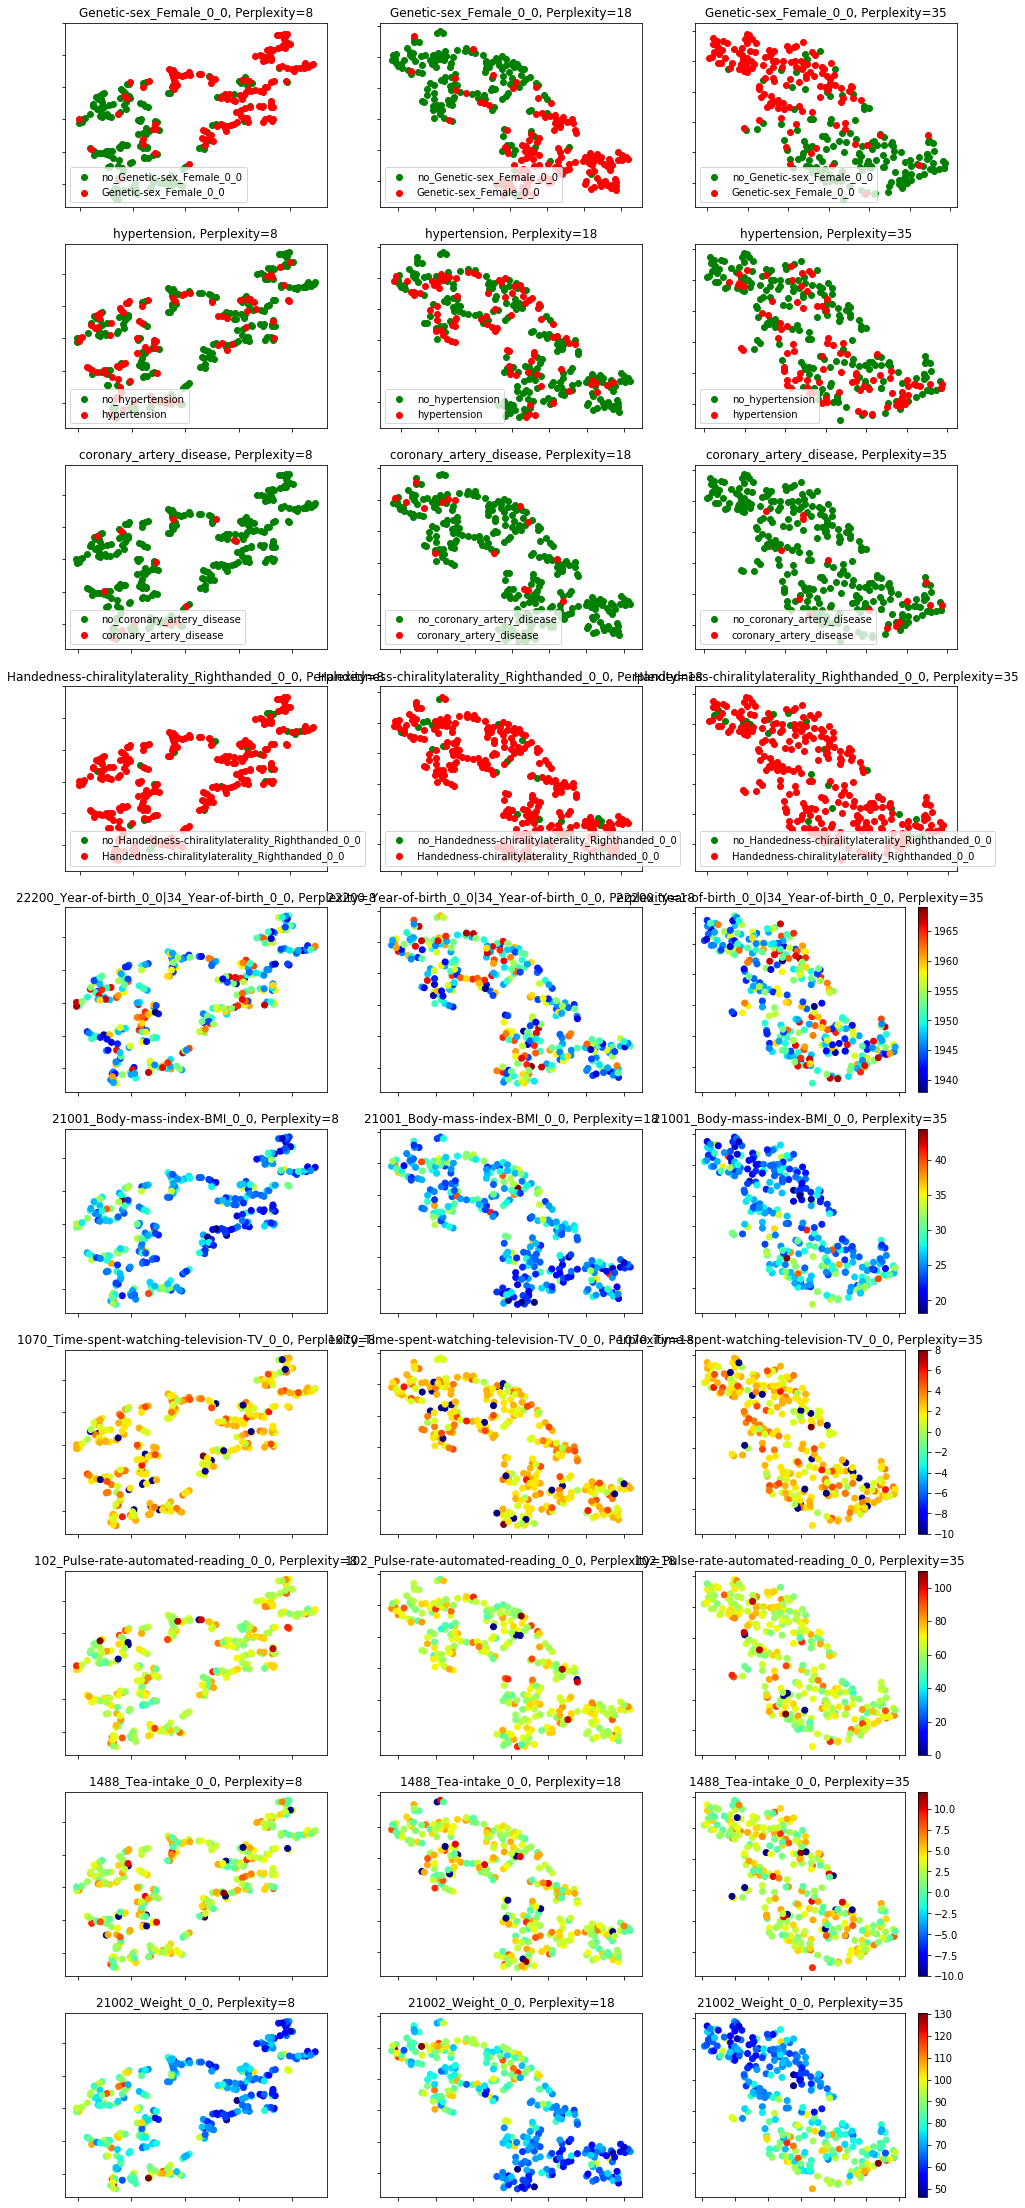

In [8]:
n_components = 2
max_rows = 10
(fig, subplots) = plt.subplots(min(max_rows, len(label_dict)), 3, figsize=(16, max_rows*4))
perplexities = [8, 18, 35]

p2y = {}
for i, perplexity in enumerate(perplexities):
    tsne = manifold.TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity)
    p2y[perplexity] = tsne.fit_transform(x_embed)

j = -1
for k in label_dict:
    j += 1
    if j == max_rows:
        break
    if k in categorical_labels:
        red = label_dict[k] == 1.0
        green = label_dict[k] != 1.0
    elif k in continuous_labels:
        colors = label_dict[k]       
    print('process key:', k)
    for i, perplexity in enumerate(perplexities):
        ax = subplots[j, i]
        ax.set_title(k+", Perplexity=%d" % perplexity)
        if k in categorical_labels:
            ax.scatter(p2y[perplexity][green, 0], p2y[perplexity][green, 1], c="g")
            ax.scatter(p2y[perplexity][red, 0], p2y[perplexity][red, 1], c="r")
            ax.legend(['no_'+k, k], loc='lower left')
        elif k in continuous_labels:
            points = ax.scatter(p2y[perplexity][:, 0], p2y[perplexity][:, 1], c=colors, cmap='jet') 
            if i == len(perplexities)-1:
                fig.colorbar(points, ax=ax)
                
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
plt.show()
